# Predict Selling Prices of Properties - The Corcoran Group
Xiaojing (Vicky) Dong  
June 3, 2018

## I. Data Cleansing and Exploration

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

In [35]:
# Read data
df = pd.read_csv("nyc-rolling-sales.csv")

#### Remove useless columns

In [3]:
del df['Unnamed: 0']
del df['EASE-MENT'] # with all value missing

#### `SALE PRICE`

In [4]:
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')
# Remove rows with missing SALE PRICE
df = df.dropna(subset=['SALE PRICE'])
# Remove rows with zero SALE PRICE
df = df[(df['SALE PRICE'] > 0)]

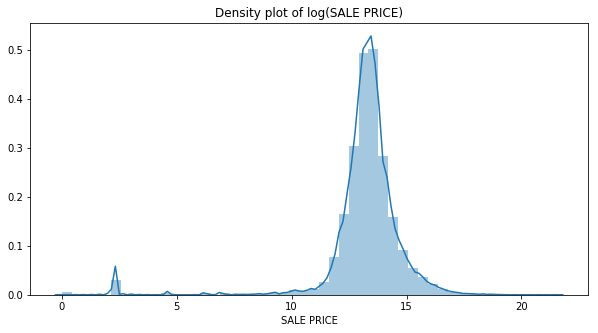

In [5]:
plt.figure(figsize=(10, 5))
sns.distplot(np.log(df['SALE PRICE']))
plt.title('Density plot of log(SALE PRICE)')
plt.show()

In [6]:
# According to the density plot, log(SALE PRICE) appears to be approximately normal.
# Thus, consider removing rows with "abnormal" SALE PRICE based on the IQR rule.
df = df[(df['SALE PRICE'] > 110000) & (df['SALE PRICE'] < 4500000)]

#### Create `SALE MONTH` from `SALE DATE`

In [7]:
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'], errors='coerce')
df['SALE MONTH'] = df['SALE DATE'].map(lambda x: x.month)

####  `YEAR BUILT`

In [8]:
# Replace YEAR BUILT earlier than 1800 by NaN
df['YEAR BUILT'][df['YEAR BUILT'] < 1800] = np.nan

#### `LAND SQUARE FEET` and `GROSS SQUARE FEET`
- About 1/3 of data contains missing values
    - Tentatively, rows with missing values are not removed to keep more information
- Also noticed that some observations have zero values for one or both variables, which requires further investigation

In [9]:
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET']= pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')

#### `RESIDENTIAL UNITS`, `COMMERCIAL UNITS`, and `TOTAL UNITS`

- High multicollinearity exists
    - For most observations, `TOTAL UNITS` equals the sum of `RESIDENTIAL UNITS` and `COMMERCIAL UNITS`

In [10]:
# Remove rows with TOTAL UNITS smaller than max(RESIDENTIAL UNITS, COMMERCIAL UNITS)
df = df[df['TOTAL UNITS'] >= df[['COMMERCIAL UNITS','RESIDENTIAL UNITS']].max(axis = 1)]

#### Plot correlation heatmap for numeric variables

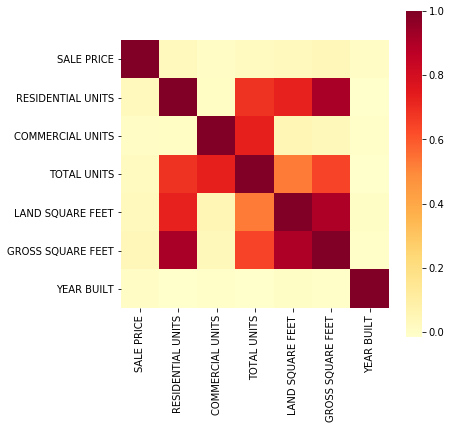

In [11]:
# Remove duplicated rows
df_cleaned = df.drop_duplicates(df.columns, keep='first')

df_numeric = df_cleaned[['SALE PRICE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 
                         'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT']]
corr = df_numeric.corr()

plt.figure(figsize=(6,6))
sns.heatmap(corr, square = True, cmap = "YlOrRd")
plt.show()

#### Convert categorical variables into dummies

- Following variables are not used for model fitting
    - `APARTMENT NUMBER`: unstructured and cannot extract meaningful information from it
    - `NEIGHBORHOOD`, `ZIP CODE` and `ADDRESS`: dropped because of too many levels
    - `BUILDING CLASS AT PRESENT`, `BUILDING CLASS AT TIME OF SALE`: having too many levels, use `BUILDING CLASS CATEGORY` only
    - `SALE DATE`: having too many levels, use `SALE MONTH` only
    - `BLOCK`: subdivision of `BOROUGH`, not meaningful on its own
    - `LOT`: subdivision of `BLOCK`, not meaningful on its own

In [12]:
df_cleaned['BOROUGH'] = df_cleaned['BOROUGH'].astype('category')
df_cleaned['TAX CLASS AT TIME OF SALE'] = df_cleaned['TAX CLASS AT TIME OF SALE'].astype('category')
df_cleaned['SALE MONTH'] = df_cleaned['SALE MONTH'].astype('category')

df_categorical = df_cleaned[['BOROUGH', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT',
                             'TAX CLASS AT TIME OF SALE', 'SALE MONTH']]
df_dummies = pd.get_dummies(df_categorical)

In [13]:
# Cleaned data for model fitting
df_cleaned = pd.concat([df_numeric, df_dummies], axis = 1)
df_cleaned.shape

(54124, 79)

In [14]:
df_cleaned.head()

,SALE PRICE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,BOROUGH_1,BOROUGH_2,BOROUGH_3,...,SALE MONTH_3,SALE MONTH_4,SALE MONTH_5,SALE MONTH_6,SALE MONTH_7,SALE MONTH_8,SALE MONTH_9,SALE MONTH_10,SALE MONTH_11,SALE MONTH_12
3,3936272.0,10,0,10,2272.0,6794.0,1913.0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
6,3192840.0,8,0,8,1750.0,4226.0,1920.0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
13,499000.0,0,0,0,NaN,NaN,1920.0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
15,529500.0,0,0,0,NaN,NaN,1920.0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
16,423000.0,0,0,0,NaN,NaN,1920.0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [15]:
X = df_cleaned.drop(['SALE PRICE'], axis = 1)
# Perform log transformation on SALE PRICE
y = np.log(df_cleaned['SALE PRICE'])
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## II. Model Fitting and Selection (For replicating results, please skip to III. Model Evaluation)

- Based on previous findings of data cleaning, consider using Extreme Gradient Boosting regression because it
    - can handle missing data in a natural way, which is most desirable in this project because around 1/3 of our data contains missing values
    - can capture complex non-linear relationships and potential interactions
    - is regularized and less likely to overfit
    - is robust to the existence of multicollinearity and outliers

In [27]:
dtrain = xgb.DMatrix(data = X_train, label = y_train) 
dtest = xgb.DMatrix(data = X_test, label = y_test)

params = {'learning_rate': 0.1, 'n_estimators': 1000,
          'max_depth': 5, 'min_child_weight': 1,
          'gamma': 0, 
          'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'seed': 1}
cv_result = xgb.cv(params, dtrain, num_boost_round = 1000, nfold = 5,
                   metrics = 'rmse', early_stopping_rounds = 50)
cv_result.tail()

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
617,0.489972,0.002688,0.438975,0.001378
618,0.489972,0.002695,0.438909,0.001378
619,0.489964,0.002697,0.438846,0.001382
620,0.489928,0.002707,0.438768,0.001380
621,0.489921,0.002704,0.438717,0.001403


#### Tune max_depth and min_child_weight

In [ ]:
cv_params_1 = {'max_depth': range(3,8,2), 
               'min_child_weight': range(1,6,2)}
params_1 = {'learning_rate': 0.1, 'n_estimators': 621,
            'gamma': 0,
            'subsample': 0.8, 'colsample_bytree': 0.8,
            'objective': 'reg:linear', 'seed': 2}
optimized_GBM_1 = GridSearchCV(estimator = XGBRegressor(**params_1), param_grid = cv_params_1, 
                               scoring = 'mean_squared_error', cv = 5, n_jobs = -1, verbose = 10)
optimized_GBM_1.fit(X_train, y_train)

In [37]:
print("Optimal parameter: %s" % optimized_GBM_1.best_params_)
print("Optimal MSE: %s" % optimized_GBM_1.best_score_)
optimized_GBM_1.grid_scores_

Optimal parameter: {'max_depth': 5, 'min_child_weight': 1}
Optimal MSE: -0.2406159017711632


[mean: -0.24635, std: 0.00485, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: -0.24674, std: 0.00454, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: -0.24682, std: 0.00472, params: {'max_depth': 3, 'min_child_weight': 5},
 mean: -0.24062, std: 0.00445, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: -0.24124, std: 0.00472, params: {'max_depth': 5, 'min_child_weight': 3},
 mean: -0.24132, std: 0.00438, params: {'max_depth': 5, 'min_child_weight': 5},
 mean: -0.24207, std: 0.00435, params: {'max_depth': 7, 'min_child_weight': 1},
 mean: -0.24219, std: 0.00396, params: {'max_depth': 7, 'min_child_weight': 3},
 mean: -0.24226, std: 0.00423, params: {'max_depth': 7, 'min_child_weight': 5}]

#### Tune gamma

In [ ]:
cv_params_2 = {'gamma': [0.05*i for i in range(0,5)]}
params_2 = {'learning_rate': 0.1, 'n_estimators': 621,
            'max_depth': 5, 'min_child_weight': 1,
            'subsample': 0.8, 'colsample_bytree': 0.8,
            'objective': 'reg:linear', 'seed': 3}
optimized_GBM_2 = GridSearchCV(estimator = XGBRegressor(**params_2), param_grid = cv_params_2, 
                               scoring = 'mean_squared_error', cv = 5, n_jobs = -1, verbose = 10)
optimized_GBM_2.fit(X_train, y_train)

In [49]:
print("Optimal parameter: %s" % optimized_GBM_2.best_params_)
print("Optimal MSE: %s" % optimized_GBM_2.best_score_)
optimized_GBM_2.grid_scores_

Optimal parameter: {'gamma': 0.05}
Optimal MSE: -0.2403368216588127


[mean: -0.24041, std: 0.00479, params: {'gamma': 0.0},
 mean: -0.24034, std: 0.00481, params: {'gamma': 0.05},
 mean: -0.24046, std: 0.00462, params: {'gamma': 0.1},
 mean: -0.24048, std: 0.00492, params: {'gamma': 0.15000000000000002},
 mean: -0.24048, std: 0.00478, params: {'gamma': 0.2}]

In [51]:
params = {'learning_rate': 0.1, 'n_estimators': 1000,
          'max_depth': 5, 'min_child_weight': 1,
          'gamma': 0.05, 
          'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'seed': 1}
cv_result = xgb.cv(params, dtrain, num_boost_round = 1000, nfold = 5,
                   metrics = 'rmse', early_stopping_rounds = 50)
cv_result.tail()

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
576,0.489715,0.002068,0.441567,0.001541
577,0.489688,0.002056,0.441497,0.001524
578,0.489664,0.002034,0.441417,0.001510
579,0.489655,0.002036,0.441373,0.001517
580,0.489650,0.002032,0.441322,0.001510


#### Tune subsample and colsample_bytree

In [ ]:
cv_params_3 = {'subsample': [0.05*i for i in range(16,20)], 
               'colsample_bytree': [0.05*i for i in range(16,20)]}
params_3 = {'learning_rate': 0.1, 'n_estimators': 580,
            'max_depth': 5, 'min_child_weight': 1,
            'gamma': 0.05,
            'objective': 'reg:linear', 'seed': 4}
optimized_GBM_3 = GridSearchCV(estimator = XGBRegressor(**params_3), param_grid = cv_params_3, 
                               scoring = 'mean_squared_error', cv = 5, n_jobs = -1, verbose = 10)
optimized_GBM_3.fit(X_train, y_train)

In [67]:
print("Optimal parameter: %s" % optimized_GBM_3.best_params_)
print("Optimal MSE: %s" % optimized_GBM_3.best_score_)
optimized_GBM_3.grid_scores_

Optimal parameter: {'colsample_bytree': 0.8, 'subsample': 0.9500000000000001}
Optimal MSE: -0.2396489269057489


[mean: -0.24043, std: 0.00423, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
 mean: -0.24052, std: 0.00460, params: {'colsample_bytree': 0.8, 'subsample': 0.8500000000000001},
 mean: -0.24040, std: 0.00424, params: {'colsample_bytree': 0.8, 'subsample': 0.9},
 mean: -0.23965, std: 0.00417, params: {'colsample_bytree': 0.8, 'subsample': 0.9500000000000001},
 mean: -0.24053, std: 0.00477, params: {'colsample_bytree': 0.8500000000000001, 'subsample': 0.8},
 mean: -0.24007, std: 0.00466, params: {'colsample_bytree': 0.8500000000000001, 'subsample': 0.8500000000000001},
 mean: -0.24000, std: 0.00441, params: {'colsample_bytree': 0.8500000000000001, 'subsample': 0.9},
 mean: -0.23989, std: 0.00412, params: {'colsample_bytree': 0.8500000000000001, 'subsample': 0.9500000000000001},
 mean: -0.24050, std: 0.00454, params: {'colsample_bytree': 0.9, 'subsample': 0.8},
 mean: -0.24039, std: 0.00410, params: {'colsample_bytree': 0.9, 'subsample': 0.8500000000000001},
 mean: -0.23992, std: 0.0

In [68]:
params = {'learning_rate': 0.1, 'n_estimators': 1000,
          'max_depth': 5, 'min_child_weight': 1,
          'gamma': 0.05, 
          'subsample': 0.95, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'seed': 1}
cv_result = xgb.cv(params, dtrain, num_boost_round = 1000, nfold = 5,
                   metrics = 'rmse', early_stopping_rounds = 50)
cv_result.tail()

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
574,0.489119,0.002319,0.442002,0.000828
575,0.489120,0.002330,0.441934,0.000844
576,0.489109,0.002327,0.441877,0.000826
577,0.489090,0.002346,0.441814,0.000809
578,0.489071,0.002324,0.441755,0.000833


## III. Model Evaluation on Test Data

In [18]:
# Optimal model with parameters selected above
model = XGBRegressor(learning_rate = 0.1, n_estimators = 578,
                     max_depth = 5, min_child_weight = 1,
                     gamma = 0.05,
                     subsample = 0.95, colsample_bytree = 0.8,
                     objective = 'reg:linear', seed = 1)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.05, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=578, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=1, silent=True, subsample=0.95)

In [28]:
# Predict on test data
y_pred = model.predict(X_test)
# Report the test RMSE and R-squared
print("Test Root Mean Squared Error: {}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
print("Test R-squared: {}".format(r2_score(y_test, y_pred)))

Test Root Mean Squared Error: 0.4881533612302596
Test R-squared: 0.5609492224494851


#### Plot the feature importances
- The 15 most important features in the Extreme Gradient Boosting regression appear to be
    - Age: `YEAR BUILT`,
    - Size: `LAND SQUARE FEET` and `GROSS SQUARE FEET`
    - Number of units: `RESIDENTIAL UNITS`, `TOTAL UNITS` and `COMMERCIAL UNITS`
    - Location: `BOROUGH`
    - `SALE MONTH` (extracted from `SALE DATE`)

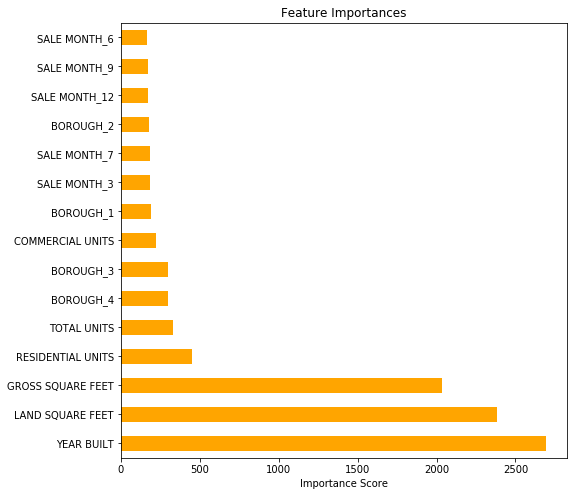

In [34]:
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending = False)
feat_imp.iloc[0:15].plot(kind = 'barh', title = 'Feature Importances', figsize = (8,8), color = 'orange')
plt.xlabel('Importance Score')
plt.show()